In [1]:
#!/usr/bin/env python
# =============== import library ======================
from __future__ import print_function, division
from std_msgs.msg import Float32MultiArray,MultiArrayDimension
from sensor_msgs.msg import Image,CameraInfo
from autoware_msgs.msg import PointsImage
from geometry_msgs.msg import PoseArray , Pose , PoseStamped
from autoware_msgs.msg import LaneArray,Lane,Waypoint

import rospkg
import rospy
import tf

from cv_bridge import CvBridge
import time

import cv2
import numpy as np
import os
import sys

import matplotlib.pylab as plt

segment = 20
delta_y = 20
main_point_raw = []

In [2]:

'''
=============== Subscribe  /mainpoint ======================
* Subscribe /points_image
* Subscribe /main_point
* Subscribe /points_image
* Subscribe /points_image
* Subscribe /Drive/main_point
* Subscribe /camera_info
* Subscribe /current_pose
'''
class Img_Sub():
    def __init__(self):
        self.points_image_sub = rospy.Subscriber("/points_image", PointsImage, self.callback)
        self.pred_max_sub = rospy.Subscriber("/Drive/pred_max", Image, self.area_callback)
        self.points_image_ok = False
        self.area_ok = False
        self.distance = np.zeros((576, 1024)).astype(np.float)
        self.pred_max = np.zeros((576, 1024,3)).astype(np.float)
        self.bridge = CvBridge()
    def callback(self, msg):

        image_height,image_width = msg.image_height,msg.image_width
        self.distance = np.array(msg.distance).reshape((image_height,image_width))
        
        self.points_image_ok = True
    def area_callback(self,msg):
        self.pred_max = self.bridge.imgmsg_to_cv2(msg,'bgr8')
        self.area_ok = True
class Main_Point_Sub():
    def __init__(self):
        self.mainpoint_sub = rospy.Subscriber("Drive/main_point", Float32MultiArray,self.callback)
    def callback(self, msg):
        global main_point_raw
        main_point_raw = msg.data

class CameraInfo_Sub():
    def __init__(self):
        self.camera_sub = rospy.Subscriber("/usb_camc/camera_info", CameraInfo,self.callback)
        self.F_intrc_inv =  np.zeros((3,3))
        self.camera_ok = False
    def callback(self, msg):
        F_intrc = np.array(msg.P)
        F_intrc = F_intrc.reshape((3,4))[:,:3]
        F_intrc_inv = np.linalg.inv(F_intrc)
        self.F_intrc_inv = F_intrc_inv
        self.camera_ok = True

class CurrentPose_Sub():
    def __init__(self):
        self.camera_sub = rospy.Subscriber("/current_pose", PoseStamped ,self.callback)
    def callback(self, msg):
        # A Pose with reference coordinate frame and timestamp
        #Header header
        #Pose pose
        x ,y ,z, w = msg.pose.orientation.x,msg.pose.orientation.y,msg.pose.orientation.z,msg.pose.orientation.w
        
        r,p,y = tf.transformations.euler_from_quaternion((x,y,z,w))





        
class tf_listen_class():
    def __init__(self):
        self.listener = tf.TransformListener()
        now = rospy.Time.now()
        self.trans = [0,0,0]
        self.rot = [0,0,0,0]
        self.projection_matrix = np.zeros((4,4))
        
    def wait_update_transform(self):
        t = self.listener.waitForTransform('/map','/camerac',rospy.Time.now(), rospy.Duration(500.0))
        (trans, rot) = self.listener.lookupTransform('/map', '/camerac', rospy.Time())
        
        # update rot trans matrix
        self.trans = trans
        self.rot = rot
        self.projection_matrix = self.listener.fromTranslationRotation(trans,rot)

       
    def transformPose(self,points):
        lane_array = LaneArray()
        lane = Lane()
        lane.header.frame_id='map'
        
        
        points = np.array(points)
        points_in_map = np.dot(self.projection_matrix,points.transpose()).transpose()
        for i in range(len(points)):
            waypoint = Waypoint()
            p1 = PoseStamped()
            p1.header.frame_id = 'map'
            p1.pose.position.x,p1.pose.position.y,p1.pose.position.z = points_in_map[i][0],points_in_map[i][1],points_in_map[i][2]
            if i != len(points)-1:
                dif_x,dif_y,dif_z = points_in_map[i+1][0]-points_in_map[i][0],points_in_map[i+1][1]-points_in_map[i][1],points_in_map[i+1][2]-points_in_map[i][2]
                yaw = np.angle([dif_x+dif_y*1j])
                quaternion = tf.transformations.quaternion_from_euler(0,0,yaw)

                p1.pose.orientation.x,p1.pose.orientation.y,p1.pose.orientation.z,p1.pose.orientation.w = quaternion
                
            else:
                p1.pose.orientation.x,p1.pose.orientation.y,p1.pose.orientation.z,p1.pose.orientation.w = 0,0,0,1 #forward
            waypoint.pose = p1
            waypoint.twist.twist.linear.x =1.
            lane.waypoints.append(waypoint)

        lane_array.lanes.append(lane)
        return lane_array




















    

# =============== Publish Loop  ======================
rospy.init_node('MTSAN_PoseTransform', anonymous=True)


/home/ivslab/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: SyntaxWarning: The publisher should be created with an explicit keyword argument 'queue_size'. Please see http://wiki.ros.org/rospy/Overview/Publishers%20and%20Subscribers for more information.
  if sys.path[0] == '':


MTSAN: camera info not ready
MTSAN: camera info not ready


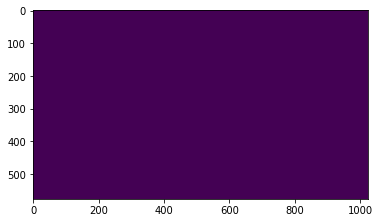

[-1 -1 -1 -1 -1 -1  0  0  0  0  0 -1 -1 -1 -1 -1  1  1  1  1  1  2  2  2
  2  2  2  2  3  3  3  3  3  3  3  4  4  4  4  4  4  5  5  5  5  5  5  6
  6  6  6  6  6  7  7  7  7  7  7  8  8  8  8  8  8  8  9  9  9  9  9  9
 10 10 10 10 10 10 11 11 11 11 11]
[[ 2.29643106  2.54738474 40.          1.        ]
 [ 2.12622833  2.48919439 32.          1.        ]
 [ 1.50671506  2.13687921 29.          1.        ]
 [ 1.77776742  2.28927875 26.          1.        ]
 [ 1.9079324   2.35715461 24.          1.        ]
 [ 1.70664799  2.25863147 21.          1.        ]
 [ 1.24593472  2.0378449  19.          1.        ]
 [ 1.01523852  1.83807123 16.          1.        ]
 [ 0.87529105  1.7868017  14.          1.        ]
 [ 0.94991571  1.79303753 11.          1.        ]
 [ 1.2663306   1.97261155  8.          1.        ]
 [ 0.59505177  1.59588301  6.          1.        ]]


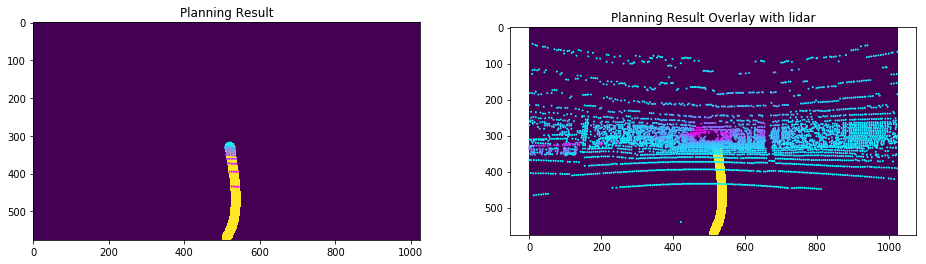

update


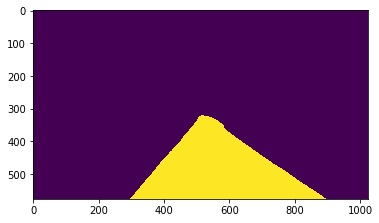

[-1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0  0  1  1  1  1  1  1  2  2  2
  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4  4  5  5  5  5  5  5  6  6
  6  6  6  6  7  7  7  7  7  7  8  8  8  8  8]
[[ 2.0487597   2.47369003 27.          1.        ]
 [ 1.74436378  2.2834692  25.          1.        ]
 [ 1.59727287  2.26518226 22.          1.        ]
 [ 1.31820381  2.16202044 20.          1.        ]
 [ 1.00666451  1.88984716 17.          1.        ]
 [ 1.48017466  2.18412209 14.          1.        ]
 [ 1.43357372  2.09296775 11.          1.        ]
 [ 0.80864549  1.77529705  9.          1.        ]
 [ 0.90616149  1.82905865  6.          1.        ]]


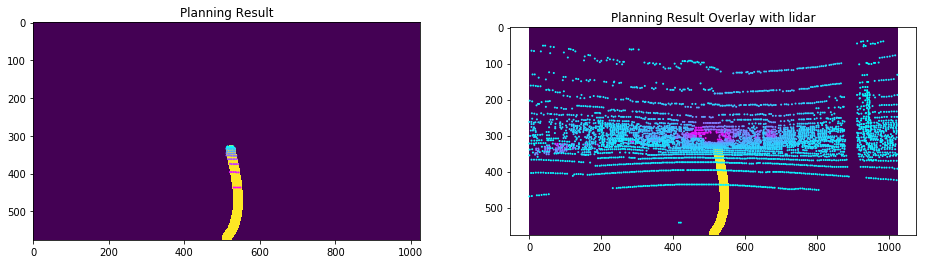

update


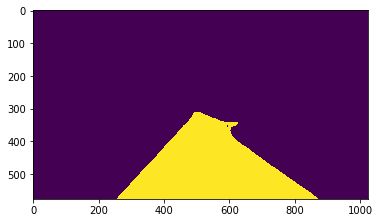

[-1 -1 -1 -1  0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  2  3  3  3  3
  3  3  4  4  4  4  4  4  5  5  5  5  5 -1  6  6  6  6  6  6  7  7  7  7
  7  7  8  8  8  8  8  8  9  9  9  9  9  9 10 10 10 10 10 10 11 11 11 11
 11 11 12 12 12 12 12 12 13 13 13 13 13 13 14 14 14 14 14 14]
[[ 1.59722924  2.49908113 43.          1.        ]
 [ 1.09973323  2.13004541 36.          1.        ]
 [ 1.19524133  2.10799122 32.          1.        ]
 [ 0.83164805  1.8462671  29.          1.        ]
 [ 1.22332764  2.14319396 27.          1.        ]
 [ 0.42873779  1.6790241  25.          1.        ]
 [ 0.43997237  1.64567292 23.          1.        ]
 [ 0.7153669   1.77530479 21.          1.        ]
 [ 0.4714283   1.67487204 19.          1.        ]
 [ 0.84921902  1.86181545 17.          1.        ]
 [ 0.41682801  1.57225454 15.          1.        ]
 [ 0.64592654  1.76438332 13.          1.        ]
 [ 1.11430156  1.97561502 10.          1.        ]
 [ 0.85838026  1.81814349  8.          1.        ]
 [ 0.

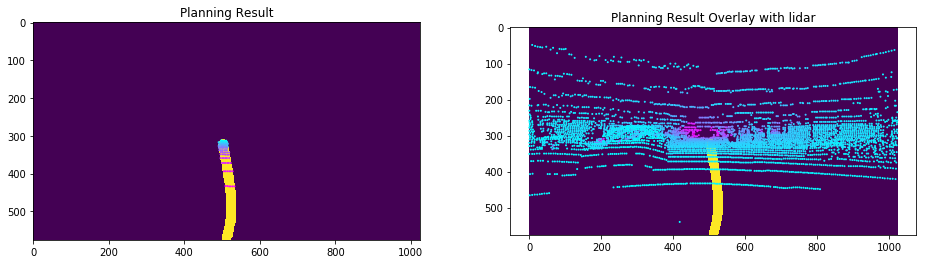

update


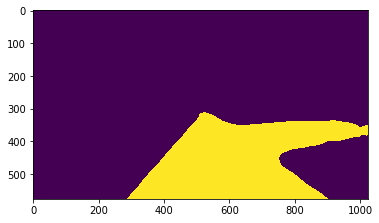

[-1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0  1  1  1  1  1  1 -1  2  2  2
  2  2  3  3  3  3  3  3  4  4  4  4  4  4  5  5  5  5  5  5  5  6  6  6
  6  6  6  7  7  7  7  7  7  8  8  8  8  8  8  9  9  9  9  9  9  9 10 10
 10 10 10 10 -1 11 11 11 11 11 12 12 12 12 12 12 13 13 13 13 13 13]
[[ 2.73058653  2.21863413 39.          1.        ]
 [ 2.75398898  2.2449944  34.          1.        ]
 [ 2.80532479  2.25678182 30.          1.        ]
 [ 2.22979021  2.07360244 29.          1.        ]
 [ 2.07970333  2.04412651 26.          1.        ]
 [ 1.80401909  1.85690725 24.          1.        ]
 [ 1.97199917  1.95788348 22.          1.        ]
 [ 2.05883956  2.07114005 19.          1.        ]
 [ 1.98265612  2.09679222 17.          1.        ]
 [ 1.23996472  1.63338685 15.          1.        ]
 [ 1.32184947  1.76083517 13.          1.        ]
 [ 1.69959295  2.01846218 10.          1.        ]
 [ 1.40195084  1.9311291   8.          1.        ]
 [ 0.84837312  1.67841148  6.          1.        ]

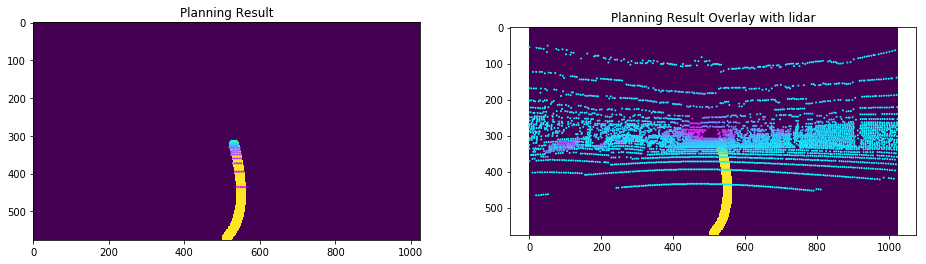

update


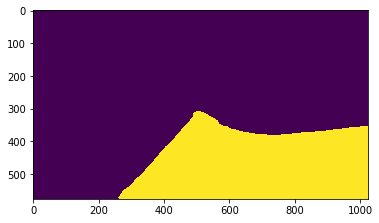

[-1 -1 -1  0  0  0  0  0  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  2  2  2  2  2  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  5  5  5  5
  5  5  5  5  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  8  8  8  8  8
  8  8  8  9  9  9  9  9  9  9 10 10 10 10 10 10 10 11 11 11 11 11 11 11
 12 12 12 12 12 12 13 13 13 13 13 13 14 14 14 14 14]
[[ 1.6527698   2.13414478 45.          1.        ]
 [ 1.72730112  2.33642507 42.          1.        ]
 [ 1.34976125  1.78016984 32.          1.        ]
 [ 1.57691348  2.10300827 28.          1.        ]
 [ 1.37330353  1.99808276 27.          1.        ]
 [ 1.65010405  2.09679675 24.          1.        ]
 [ 0.91413772  1.63557529 23.          1.        ]
 [ 1.26499689  1.81924367 21.          1.        ]
 [ 1.04005313  1.64921844 19.          1.        ]
 [ 1.19457221  1.77265108 17.          1.        ]
 [ 1.46865928  1.84598446 14.          1.        ]
 [ 1.61745918  1.96029413 12.          1.        ]
 [ 1.28423536  1.72535503 10.          1.  

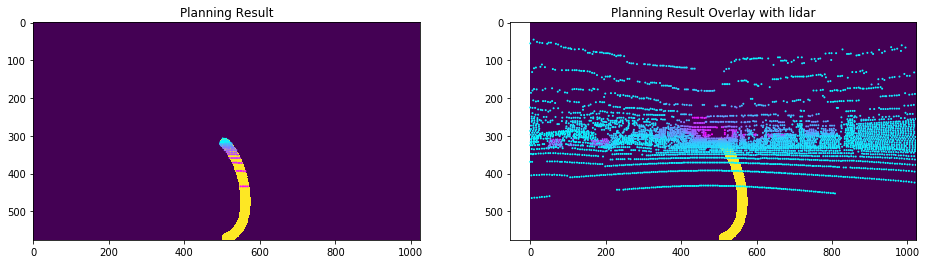

update


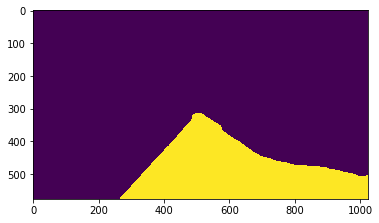

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0  1  1  1  1  1  1 -1 -1
 -1 -1 -1 -1  2  2  2  2  2  2  3  3  3  3  3  4  4  4  4  4  5  5  5  5
  5  5  5  6  6  6  6  6  6  7  7  7  7  7  7  8  8  8  8  8  8  8  9  9
  9  9  9  9 10 10 10 10 10 10 -1 -1 -1 -1 -1 -1 11 11 11 11 11 11]
[[ 1.48577714  2.75507379 45.          1.        ]
 [ 1.32721579  2.52746129 39.          1.        ]
 [ 0.82551879  2.20787787 33.          1.        ]
 [ 1.11824799  2.29384232 29.          1.        ]
 [ 1.23967469  2.2923665  26.          1.        ]
 [ 1.16303229  2.25364327 24.          1.        ]
 [ 1.21318614  2.22833848 21.          1.        ]
 [ 0.95181829  2.10279775 19.          1.        ]
 [ 0.84623843  1.91928196 16.          1.        ]
 [ 0.74052668  1.86863613 14.          1.        ]
 [ 0.91778088  1.88992131 11.          1.        ]
 [ 0.67408186  1.68250513  6.          1.        ]]


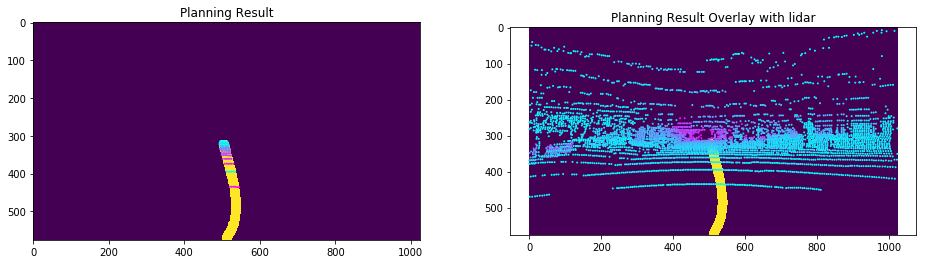

update


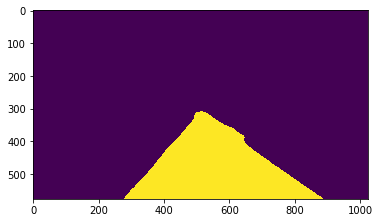

[-1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0 -1  1  1  1  1  1 -1  2  2  2  2
  2  2  3  3  3  3  3 -1  4  4  4  4  4  4  5  5  5  5  5  5  6  6  6  6
  6  6  7  7  7  7  7  7  7  8  8  8  8  8  8  9  9  9  9  9  9 10 10 10
 10 10 10 11 11 11 11 11 11 12 12 12 12 12 12 13 13 13 13 13 13 14 14 14
 14 14 14]
[[ 1.72024596  2.35318446 46.          1.        ]
 [ 1.92814636  2.29073715 38.          1.        ]
 [ 1.63035536  2.08697867 34.          1.        ]
 [ 1.77657127  2.23778677 30.          1.        ]
 [ 1.48442304  2.09734583 29.          1.        ]
 [ 1.56636155  2.12927461 26.          1.        ]
 [ 1.28429687  1.97944486 24.          1.        ]
 [ 1.49623847  2.07157087 22.          1.        ]
 [ 1.0534991   1.80778074 20.          1.        ]
 [ 1.07154191  1.88637793 18.          1.        ]
 [ 1.14667237  1.88937795 15.          1.        ]
 [ 1.24995434  1.95896924 13.          1.        ]
 [ 0.71652895  1.66258574 11.          1.        ]
 [ 1.20206058  1.95951188  8.     

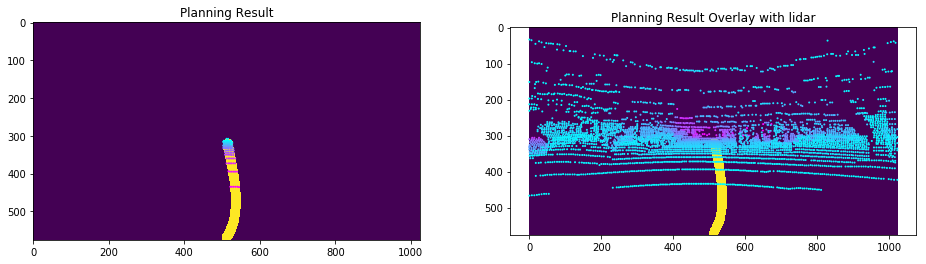

update


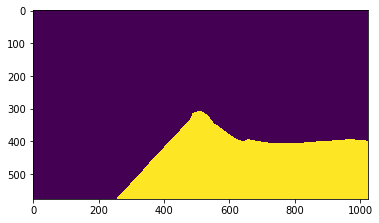

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0
  0  0  0  0 -1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1  2  2  2  2  2
  2  3  3  3  3  3  3  3  4  4  4  4  4  4  4  5  5  5  5  5  5  5 -1 -1
 -1 -1 -1 -1  6  6  6  6  6  6  7  7  7  7  7  7  8  8  8  8  8  8  9  9
  9  9  9  9]
[[ 1.44238245  2.03102756 28.          1.        ]
 [ 1.30887806  1.97726357 27.          1.        ]
 [ 0.92934936  1.71390104 23.          1.        ]
 [ 1.32157338  1.93257999 21.          1.        ]
 [ 1.03620172  1.80197084 19.          1.        ]
 [ 1.26950181  1.92704105 17.          1.        ]
 [ 0.9226138   1.67486811 13.          1.        ]
 [ 1.39507353  1.93658841 10.          1.        ]
 [ 1.11164701  1.80668128  8.          1.        ]
 [ 0.6920557   1.58916914  6.          1.        ]]


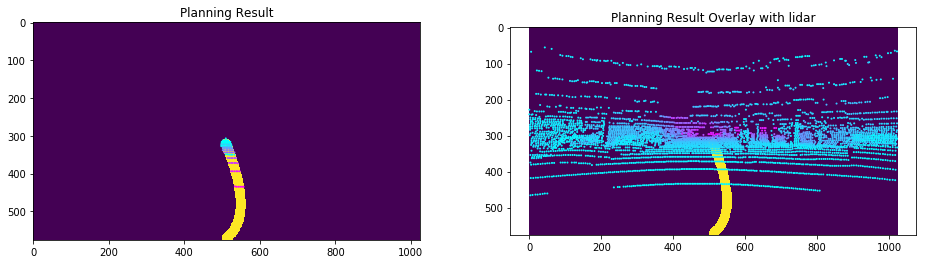

update


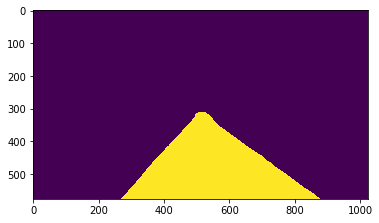

[-1 -1 -1 -1  0  0  0  0  0  1  1  1  1  1  1 -1 -1  2  2  2  2  2 -1 -1
 -1 -1 -1 -1  3  3  3  3  3  3  4  4  4  4  4  4  5  5  5  5  5 -1  5  6
  6  6  6  6  6  7  7  7  7  7  7  8  8  8  8  8  8 -1 -1 -1 -1 -1 -1  9
  9  9  9  9  9 10 10 10 10 10 10 11 11 11 11 11 11 12 12 12 12 12 12]
[[ 1.8833462   2.23451972 42.          1.        ]
 [ 1.57354009  1.96798956 35.          1.        ]
 [ 1.53440094  1.8358438  32.          1.        ]
 [ 1.40006971  1.9952755  27.          1.        ]
 [ 1.4700259   2.02829623 24.          1.        ]
 [ 0.79318428  1.64267099 23.          1.        ]
 [ 1.2553972   1.86263657 21.          1.        ]
 [ 0.95917124  1.72044814 19.          1.        ]
 [ 1.09322655  1.87491512 17.          1.        ]
 [ 0.82348567  1.68824065 13.          1.        ]
 [ 1.16549945  1.89674342 10.          1.        ]
 [ 0.94171315  1.7840296   8.          1.        ]
 [ 0.51177329  1.5594219   6.          1.        ]]


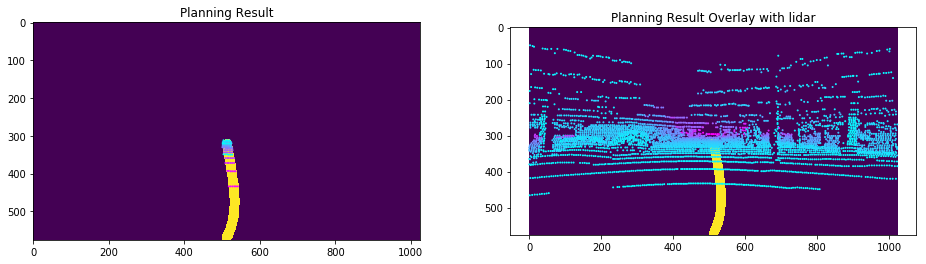

update


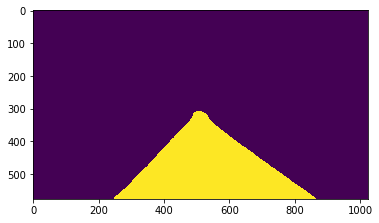

[-1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0 -1  1  1  1  1  1  1 -1 -1 -1 -1
 -1  2  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4  4  5  5  5  5
  5  5  6  6  6  6  6  6  7  7  7  7  7  7  8  8  8  8  8  8  9  9  9  9
  9  9  9 10 10 10 10 10 10 11 11 11 11 11 11 12 12 12 12 12 12 13 13 13
 13 13 13]
[[ 1.60213113  2.46600413 43.          1.        ]
 [ 0.98060888  1.99473619 37.          1.        ]
 [ 1.02881491  1.95979834 29.          1.        ]
 [ 0.73405236  1.86755359 28.          1.        ]
 [ 1.23685741  2.09157324 25.          1.        ]
 [ 1.31170046  2.09679627 23.          1.        ]
 [ 0.65283275  1.71198988 22.          1.        ]
 [ 0.90225434  1.85308349 19.          1.        ]
 [ 1.11909795  2.0443933  17.          1.        ]
 [ 0.60481352  1.66286147 15.          1.        ]
 [ 0.75077349  1.76247275 13.          1.        ]
 [ 1.14834261  1.99198973 10.          1.        ]
 [ 0.93708354  1.87245286  8.          1.        ]
 [ 0.47364703  1.59926701  6.     

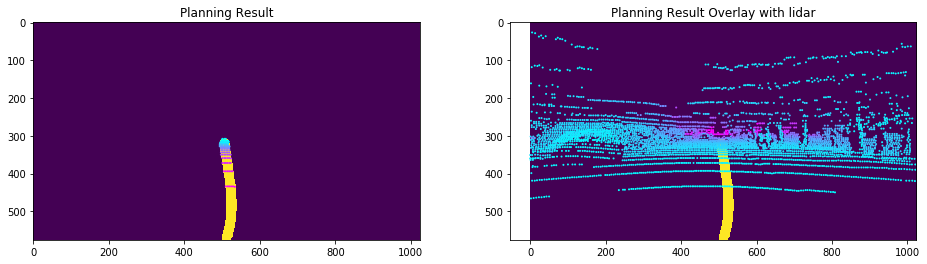

update


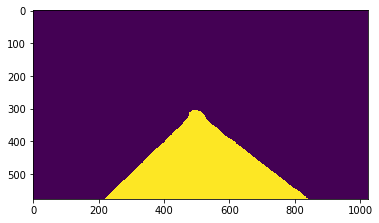

[-1 -1 -1 -1 -1 -1 -1  0  0  0  0  0 -1 -1  1  1  1  1  1  2  2  2  2  2
  2  2  3  3  3  3  3  3  3  4  4  4  4  4  4  4  5  5  5  5  5  5  5  6
  6  6  6  6  6  6  7  7  7  7  7  7  8  8  8  8  8  8  9  9  9  9  9  9
 10 10 10 10 10 10 11 11 11 11 11 11 -1 -1 -1 -1 -1 -1 12 12 12 12 12 12
 13 13 13 13 13 13 14 14 14 14 14 14]
[[ 0.99363697  2.18927145 43.          1.        ]
 [ 0.90149516  1.97257841 41.          1.        ]
 [ 0.67492914  1.82272255 35.          1.        ]
 [ 1.03998935  2.04549384 31.          1.        ]
 [ 0.93522632  1.96022666 28.          1.        ]
 [ 0.59412867  1.80977356 27.          1.        ]
 [ 0.80589092  1.88100159 24.          1.        ]
 [ 0.9687354   1.94260025 22.          1.        ]
 [ 0.580836    1.71253526 21.          1.        ]
 [ 0.53488123  1.72727108 19.          1.        ]
 [ 0.69262916  1.85662997 17.          1.        ]
 [ 0.88894647  1.88965023 14.          1.        ]
 [ 0.75918311  1.82933414 10.          1.        ]
 [ 0.67

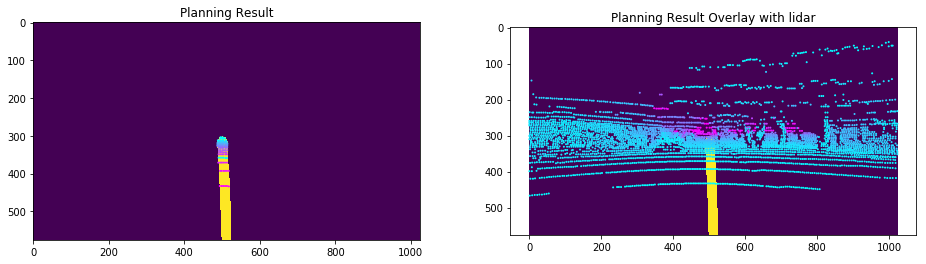

update


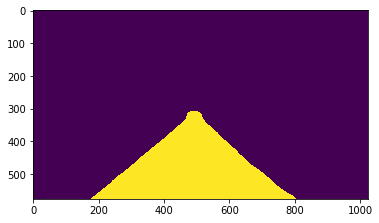

[ 0  0  0  0  0  1  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4
  4  4  4  5  5  5  5  5  5  5  6  6  6  6  6  6  6 -1  7  7  7  7  7  8
  8  8  8  8  8  9  9  9  9  9  9 10 10 10 10 10 10 11 11 11 11 11 11 12
 12 12 12 12 12 13 13 13 13 13 13 14 14 14 14 14 14 15 15 15 15 15 15]
[[6.22367740e-01 2.36361027e+00 4.70000000e+01 1.00000000e+00]
 [5.69557607e-01 2.46387601e+00 4.40000000e+01 1.00000000e+00]
 [4.12310690e-01 2.14276361e+00 3.70000000e+01 1.00000000e+00]
 [2.36523598e-01 1.97824979e+00 3.30000000e+01 1.00000000e+00]
 [3.09420913e-01 1.91504145e+00 3.00000000e+01 1.00000000e+00]
 [6.57683194e-01 2.24888921e+00 2.80000000e+01 1.00000000e+00]
 [9.19673219e-02 1.82517302e+00 2.60000000e+01 1.00000000e+00]
 [1.67798549e-01 1.73769951e+00 2.40000000e+01 1.00000000e+00]
 [2.56864965e-01 1.81897151e+00 2.20000000e+01 1.00000000e+00]
 [6.01874352e-01 1.98653710e+00 1.90000000e+01 1.00000000e+00]
 [7.25036442e-01 2.08069038e+00 1.70000000e+01 1.00000000e+00]
 [2.70042181e-01 

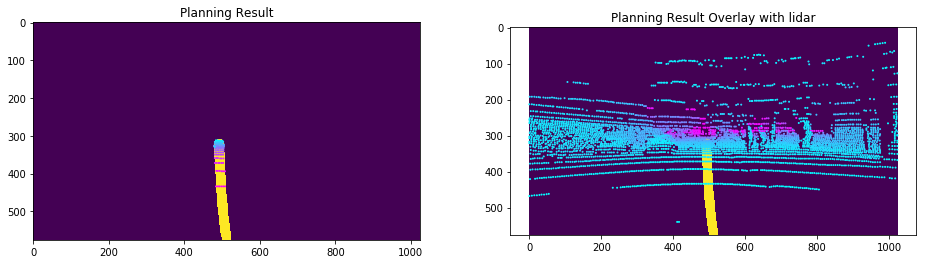

update


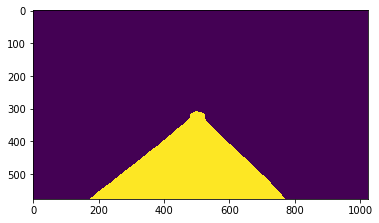

[-1 -1  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1
  1 -1 -1  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4  5  5  5  5
  5  5 -1 -1 -1 -1 -1 -1  6  6  6  6  6  6  7  7  7  7  7  7  8  8  8  8
  8  8  8  9  9  9  9  9  9 10 10 10 10 10 10 11 11 11 11 11 11 12 12 12
 12 12 12]
[[ 1.02463889  2.44668603 49.          1.        ]
 [ 1.10149074  2.33123469 34.          1.        ]
 [ 0.58163464  1.90041411 31.          1.        ]
 [ 0.55632252  2.13036823 29.          1.        ]
 [ 0.70661592  2.12982059 26.          1.        ]
 [ 0.80744714  2.09625077 24.          1.        ]
 [ 0.44729266  1.96170294 20.          1.        ]
 [ 0.48657715  1.99445117 18.          1.        ]
 [ 0.5828715   1.89584994 15.          1.        ]
 [ 0.55714703  1.93740928 13.          1.        ]
 [ 0.16152057  1.64593804 11.          1.        ]
 [ 0.7494483   1.99553621  8.          1.        ]
 [ 0.27593553  1.6945132   6.          1.        ]]


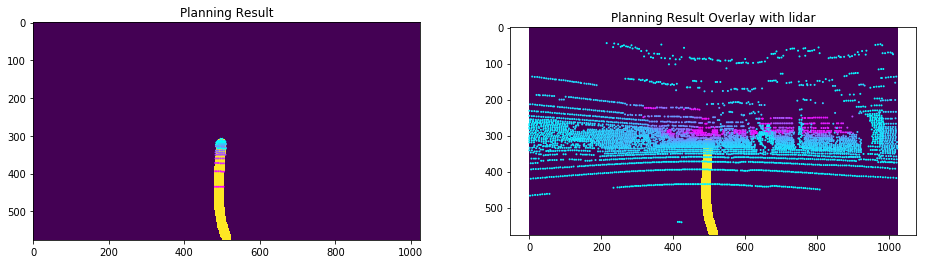

update


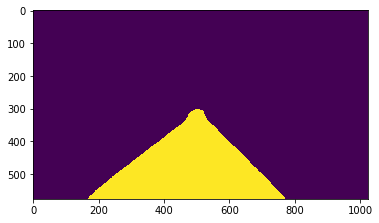

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0  0  1  1  1  1  1  1  2
  2  2  2  2  2  3  3  3  3  3  3  4  4  4  4  4  4  5  5  5  5  5  5  6
  6  6  6  6  6  7  7  7  7  7  7  8  8  8  8  8  8  9  9  9  9  9  9 10
 10 10 10 10 10 11 11 11 11 11 11 11 12 12 12 12 12 12 13 13 13 13 13 13
 14 14 14 14 14 15 15 15 15 15 15]
[[1.14131606e+00 1.81325185e+00 4.00000000e+01 1.00000000e+00]
 [1.14846575e+00 1.88993883e+00 3.80000000e+01 1.00000000e+00]
 [1.30662417e+00 1.95188582e+00 3.20000000e+01 1.00000000e+00]
 [1.12358582e+00 1.90794516e+00 2.90000000e+01 1.00000000e+00]
 [5.22894919e-01 1.53214419e+00 2.70000000e+01 1.00000000e+00]
 [1.11528146e+00 1.95406473e+00 2.50000000e+01 1.00000000e+00]
 [8.44110012e-01 1.76357079e+00 2.30000000e+01 1.00000000e+00]
 [9.77893054e-01 1.86099911e+00 2.10000000e+01 1.00000000e+00]
 [7.24796772e-01 1.73218405e+00 2.00000000e+01 1.00000000e+00]
 [7.03351736e-01 1.74855757e+00 1.80000000e+01 1.00000000e+00]
 [1.01660025e+00 1.97780216e+00 1.60000000e

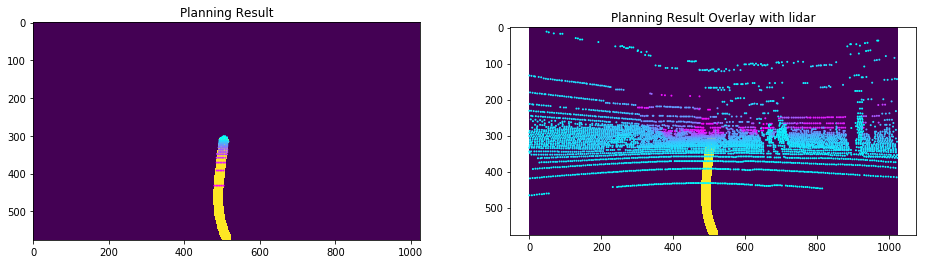

update


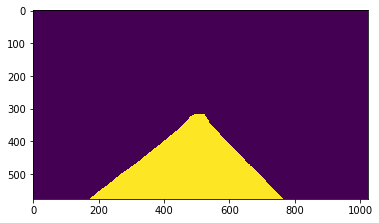

[-1 -1 -1 -1  0  0  0  0  0 -1 -1 -1 -1  1  1  1  1  1  1  2  2  2  2  2
  2  3  3  3  3  3  3  3  4  4  4  4  4  4  5  5  5  5  5  5 -1 -1 -1 -1
 -1 -1 -1  6  6  6  6  6  6  7  7  7  7  7  7  8  8  8  8  8  8  9  9  9
  9  9  9 10 10 10 10 10 10 11 11 11 11 11]
[[ 1.43565035  2.41311216 40.          1.        ]
 [ 1.36953247  2.29957557 32.          1.        ]
 [ 1.56322801  2.47341895 30.          1.        ]
 [ 1.35182834  2.35411572 27.          1.        ]
 [ 0.95324522  2.0307529  25.          1.        ]
 [ 1.15374911  2.16829896 23.          1.        ]
 [ 1.02551806  2.20595765 18.          1.        ]
 [ 1.04917812  2.13499856 15.          1.        ]
 [ 0.30343711  1.7360009  14.          1.        ]
 [ 0.57818538  1.85580742 11.          1.        ]
 [ 0.13626289  1.63938701  9.          1.        ]
 [ 0.35028157  1.74522018  6.          1.        ]]


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestCentroid

points_image_sub_node = Img_Sub()
main_point_sub_node = Main_Point_Sub()
camerainfo_sub_node  = CameraInfo_Sub()
current_pose_sub_node = CurrentPose_Sub()

tf_transform_camera_map = tf_listen_class()


posearray_pub_seg = rospy.Publisher("/lane_waypoints_array",LaneArray )
rate = rospy.Rate(1)



while not rospy.is_shutdown():
    
    if not (camerainfo_sub_node.camera_ok and points_image_sub_node.points_image_ok):
        print("MTSAN: camera info not ready")
        time.sleep(0.2)
        continue
    F_intrc_inv = camerainfo_sub_node.F_intrc_inv
    if not len(main_point_raw):
        continue

    main_point = np.array(main_point_raw).reshape(-1,2).astype(np.int32)
    
    distance  = points_image_sub_node.distance.copy()
    poly_line_mask = np.zeros(distance.shape,dtype=np.uint8)
    cv2.polylines(poly_line_mask, [main_point.reshape(-1,1,2)], False, 1, 25)
    pred_max = points_image_sub_node.pred_max.copy()
    pred_max = (pred_max[:,:,1]==255)
    plt.imshow(pred_max)
    plt.show()
    
    
    y,x = np.nonzero(distance.copy() * poly_line_mask)
#     y,x = np.nonzero(distance.copy() * (pred_max*1))
    
    # No Lidar Point in path  ---------------
    if len(x)==0:
        #     points = np.array(points)
        print('No Lidar In Path')
        posearray_pub_seg.publish(LaneArray())
        continue
    
    py,px = np.nonzero(distance)
    lidar_in_path = np.stack((y,x,distance[y,x]/100.0)).T.astype(int)
    
    
    
    points = np.stack((x*distance[y,x]/100.0,y*distance[y,x]/100.0,distance[y,x]/100.0)).T.astype(int)
    transform_points = np.ones((lidar_in_path.shape[0],4),dtype=np.float32)
    
    transform_points[:,:3] = np.dot(F_intrc_inv,points.T).T
    
    
    # No Cluster Founded  ---------------
    db = DBSCAN(eps=1, min_samples=5).fit(transform_points[:,:3])
    c = db.labels_
    print(c)
    if np.all(c<1):
        print("No clister find")
        posearray_pub_seg.publish(LaneArray())
        continue
    
    
    clf = NearestCentroid()
    clf.fit(transform_points, c)
    centroids = clf.centroids_
    
    # remove -1 class 
    if -1 in c:
        centroids= np.delete(centroids,(0),axis=0)
    #sort by distance decrease order
    centroids = centroids[centroids[:,2].argsort()[::-1]]
    print(centroids)
    
    f,ax = plt.subplots(1,2,figsize=(16,4))
    
    ax[0].imshow(poly_line_mask)
    ax[0].scatter(x,y,s=1,c=c,cmap=plt.cm.cool)
    ax[0].set_title("Planning Result")
    ax[1].imshow(poly_line_mask)
    ax[1].scatter(px,py,s=1,c=distance[py,px],cmap=plt.cm.cool)
    ax[1].set_title("Planning Result Overlay with lidar")
    plt.show()

    

#     points = np.array(points)
    tf_transform_camera_map.wait_update_transform()
    print('update')
    posearray = tf_transform_camera_map.transformPose(centroids[::-1])
    posearray_pub_seg.publish(posearray)
    rate.sleep()

In [4]:
pred_max.shape

(576, 1024, 3)

In [ ]:
centroids

In [ ]:
a = [[1.31655413e+10,1.55886486e+08, 6.48690270e+07, 8.99260000e+05,3.25129000e+06,3.54090700e+06],
 [3.83224693e+08,1.38146620e+09, 1.64204250e+07, 1.68905000e+05,1.91856700e+06,1.05264400e+06],
 [2.76656933e+08,2.24862106e+08, 4.29084116e+08, 6.19110000e+04,1.64312700e+06,1.02126800e+06],
]

In [ ]:
a = np.array(a)
b = a[:,3:]
a[:,0] = a[:,0] + b.sum(axis=1)

In [ ]:
c = a[:,:3]

In [ ]:
iu = np.diag(c) / (c.sum(axis=1) + c.sum(axis=0) - np.diag(c))

In [ ]:
iu